In [1]:
import tensorflow as tf

In [2]:
import numpy as np

X = np.load('../mount/Data_Manipulation_datasets/processed_X.npy')
Y = np.load('../mount/Data_Manipulation_datasets/processed_Y.npy')

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(60,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078 (47.18 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from sklearn.metrics import precision_score, recall_score
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[ 'accuracy', tf.keras.metrics.Precision(class_id=0), tf.keras.metrics.Recall(class_id=0)])

In [5]:
from sklearn.model_selection import train_test_split

epoch = 50 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) 

history = model.fit(X_train, Y_train, 
                    epochs=epoch, 
                    validation_split=0.2,
                    verbose=2)

Epoch 1/50
742/742 - 6s - 8ms/step - accuracy: 0.9060 - loss: 0.4671 - precision: 0.8571 - recall: 0.0757 - val_accuracy: 0.9123 - val_loss: 0.2648 - val_precision: 0.8731 - val_recall: 0.0747
Epoch 2/50
742/742 - 4s - 6ms/step - accuracy: 0.9108 - loss: 0.2611 - precision: 0.8593 - recall: 0.0687 - val_accuracy: 0.9140 - val_loss: 0.2524 - val_precision: 0.8696 - val_recall: 0.0928
Epoch 3/50
742/742 - 1s - 2ms/step - accuracy: 0.9099 - loss: 0.2547 - precision: 0.8792 - recall: 0.0723 - val_accuracy: 0.9098 - val_loss: 0.2512 - val_precision: 0.8657 - val_recall: 0.0688
Epoch 4/50
742/742 - 2s - 2ms/step - accuracy: 0.9101 - loss: 0.2532 - precision: 0.8796 - recall: 0.0719 - val_accuracy: 0.9110 - val_loss: 0.2474 - val_precision: 0.8745 - val_recall: 0.0837
Epoch 5/50
742/742 - 2s - 2ms/step - accuracy: 0.9096 - loss: 0.2516 - precision: 0.8756 - recall: 0.0726 - val_accuracy: 0.9115 - val_loss: 0.2458 - val_precision: 0.8676 - val_recall: 0.0675
Epoch 6/50
742/742 - 2s - 2ms/step 

#### functions for running metric and saving the model

In [6]:
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import os

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC


def save_model_and_performance(model, X, Y, model_name, if_test_data_provided=False):
    model_dir = os.path.join('../mount/trained_models', model_name)
    os.makedirs(model_dir)
    model.save('../mount/trained_models/{}/model.keras'.format(model_name))
    
    if if_test_data_provided:
        X_test, Y_test = X, Y
    else:
        _, X_test, _, Y_test = train_test_split(X, Y, test_size=0.2)
    
    Y_prob = model.predict(X_test)
    Y_pred = np.argmax(Y_prob, axis=1)
    
    precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y_test, Y_pred, Y_prob, save_plots_dir=model_dir)
    with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
        f.write("Precision: {}\n".format(precision))
        f.write("Recall: {}\n".format(recall))
        f.write("F1: {}\n".format(f1))
        f.write("Accuracy: {}\n".format(accuracy))
        f.write("AUC: {}\n".format(AUC))
        f.write("AUPRC: {}\n".format(AUPRC))

#### checking and saving the model

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
||>> Precision:  0.7631578947368421
||>> Recall:  0.4027777777777778
||>> F1:  0.5272727272727273
||>> Accuracy:  0.921092564491654
||>> AUC:  0.930200643573727
||>> AUPRC:  0.632742475851821


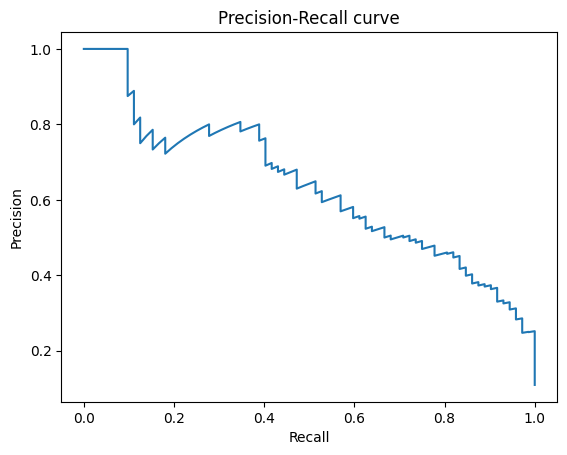

In [7]:
model_name = "NN_1"
save_model_and_performance(model, X_test, Y_test, model_name)

**Take-away** : - Even NN is showing similar performance as the different ML models, slightly better than the XG-Boost model

# Approach 2: Train the model with even number of samples from each class

In [13]:
# Same model architecture to be used 
import tensorflow as tf 

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(60,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.summary()

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[ 'accuracy', tf.keras.metrics.Precision(class_id=0), tf.keras.metrics.Recall(class_id=0)])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,078 (47.18 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

num_of_epochs = 150
model_name = "NN_balanced_1"
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1) 

X_class_0 = X_train[ Y_train == 0 ]
Y_class_0 = Y_train[ Y_train == 0 ]

num_of_class_0 = len(Y_class_0)

XY = np.concatenate((X, Y.reshape(-1,1)), axis=1)

best_loss = 1000000
best_epoch = 0
os.makedirs(f'../mount/trained_models/{model_name}', exist_ok=True)

for i in range(num_of_epochs):
    XY = XY[ XY[:, -1] == 1 ]
    XY_sels = np.random.choice(XY.shape[0], num_of_class_0)
    XY_class_1 = XY[ XY_sels ]
    X_class_1 = XY_class_1[:, :-1]
    Y_class_1 = XY_class_1[:, -1]
    X_batch = np.concatenate((X_class_0, X_class_1), axis=0)
    Y_batch = np.concatenate((Y_class_0, Y_class_1), axis=0)
    model.fit(X_batch, 
              Y_batch, 
              epochs=1, 
              validation_split=0.1,
              verbose=2)
    val_loss, val_acc, val_prec, val_recall = model.evaluate(X_test, Y_test)
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = i
        model.save(f'../mount/trained_models/{model_name}/best_model.keras')
    print(f"|| >> End of epoch {i} << ||")

185/185 - 1s - 4ms/step - accuracy: 0.8946 - loss: 0.3565 - precision_2: 0.4344 - recall_2: 0.5697 - val_accuracy: 0.8191 - val_loss: 0.4630 - val_precision_2: 1.0000 - val_recall_2: 0.1763
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.4330 - precision_2: 0.9141 - recall_2: 0.2603
|| >> End of epoch 0 << ||
185/185 - 1s - 3ms/step - accuracy: 0.8895 - loss: 0.3600 - precision_2: 0.3426 - recall_2: 0.5865 - val_accuracy: 0.8343 - val_loss: 0.4502 - val_precision_2: 1.0000 - val_recall_2: 0.1565
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8322 - loss: 0.4378 - precision_2: 0.9171 - recall_2: 0.2566
|| >> End of epoch 1 << ||
185/185 - 1s - 3ms/step - accuracy: 0.8870 - loss: 0.3659 - precision_2: 0.3816 - recall_2: 0.5676 - val_accuracy: 0.7964 - val_loss: 0.4963 - val_precision_2: 1.0000 - val_recall_2: 0.1976
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8245 - loss: 0.4430 - precision_2: 0.9177 - recall_2: 0.2651
|| >> End of epoch 2 << ||
1

In [16]:
print(f"Best loss: {best_loss} at epoch {best_epoch}")

Best loss: 0.35168182849884033 at epoch 62


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
||>> Precision:  0.46714285714285714
||>> Recall:  0.8605263157894737
||>> F1:  0.6055555555555555
||>> Accuracy:  0.8706739526411658
||>> AUC:  0.9397617671495141
||>> AUPRC:  0.6800074381392581


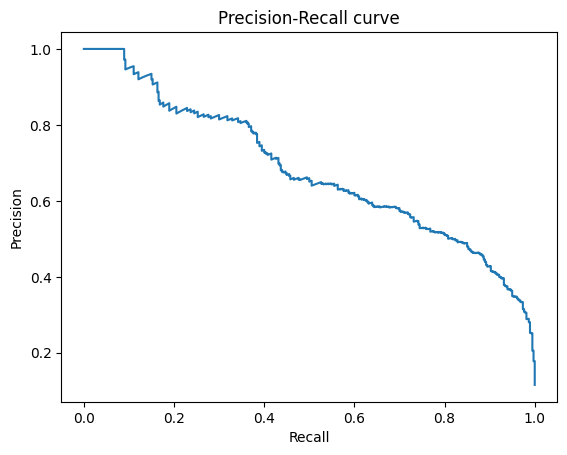

In [17]:
model_dir = os.path.join('../mount/trained_models', model_name)

best_model = tf.keras.models.load_model(os.path.join(model_dir, 'best_model.keras'))

Y_prob = best_model.predict(X_test)
Y_pred = np.argmax(Y_prob, axis=1)

precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y_test, Y_pred, Y_prob, save_plots_dir=model_dir)
with open(os.path.join(model_dir, 'metrics.txt'), 'w') as f:
    f.write("Precision: {}\n".format(precision))
    f.write("Recall: {}\n".format(recall))
    f.write("F1: {}\n".format(f1))
    f.write("Accuracy: {}\n".format(accuracy))
    f.write("AUC: {}\n".format(AUC))
    f.write("AUPRC: {}\n".format(AUPRC))